# Notebook

# Librairies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42


In [3]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Configuration graphique

In [4]:
# Thème global
sns.set_theme(
    style="whitegrid",
    context="notebook",
    palette="deep"
)
COLOR_NO_DEFAULT = "#4C72B0"   # bleu seaborn
COLOR_DEFAULT = "#DD8452"      # orange doux

# Les données

In [6]:
from pathlib import Path

DATA_DIR = Path("./data/raw")
train_path = DATA_DIR / "application_train.csv"

df = pd.read_csv(train_path)
df.shape


(307511, 122)

In [7]:
df.head()


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df["TARGET"].value_counts(normalize=True)


TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

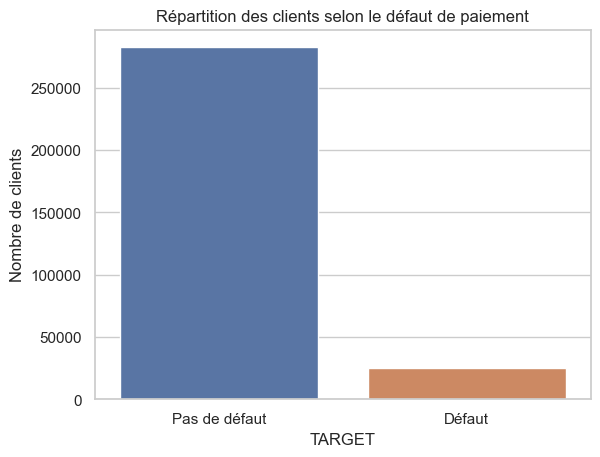

In [9]:
# graphique target
sns.barplot(
    x=df["TARGET"].value_counts().index,
    y=df["TARGET"].value_counts().values,
    palette=[COLOR_NO_DEFAULT, COLOR_DEFAULT]
)
plt.xticks([0, 1], ["Pas de défaut", "Défaut"])
plt.title("Répartition des clients selon le défaut de paiement")
plt.ylabel("Nombre de clients")
plt.show()

In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


## Valeurs manquantes

In [11]:
missing_rate = df.isna().mean().sort_values(ascending=False)
missing_rate.head(15)


COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
COMMONAREA_MEDI             0.698723
NONLIVINGAPARTMENTS_MEDI    0.694330
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_AVG        0.683550
LIVINGAPARTMENTS_MEDI       0.683550
LIVINGAPARTMENTS_MODE       0.683550
FLOORSMIN_MODE              0.678486
FLOORSMIN_AVG               0.678486
FLOORSMIN_MEDI              0.678486
YEARS_BUILD_AVG             0.664978
YEARS_BUILD_MODE            0.664978
dtype: float64

Un grand nombre de variables présente des valeurs manquantes importantes.
Certaines variables sont très incomplètes et devront être exclues ou traitées
spécifiquement lors de la phase de préparation des données.


In [12]:
df.dtypes.value_counts()


float64    65
int64      41
object     16
Name: count, dtype: int64

Le jeu de données contient un mélange de variables numériques et catégorielles.
Cette hétérogénéité nécessitera un prétraitement spécifique
(imputation, encodage) avant la modélisation.

## AGE

In [13]:
# Âge en années (plus lisible que DAYS_BIRTH)
df["AGE_YEARS"] = -df["DAYS_BIRTH"] / 365

df["AGE_YEARS"].describe()


count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: AGE_YEARS, dtype: float64

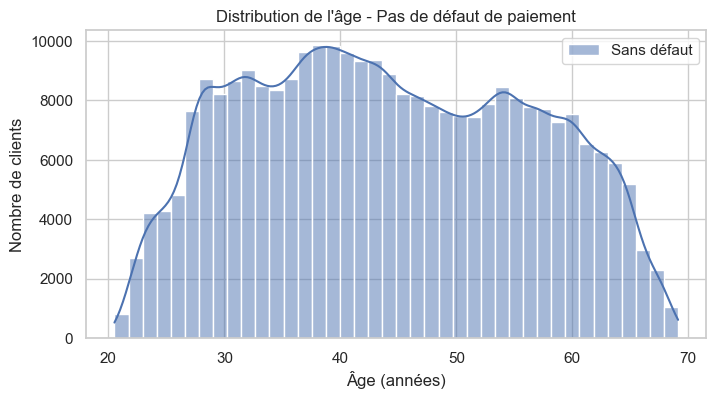

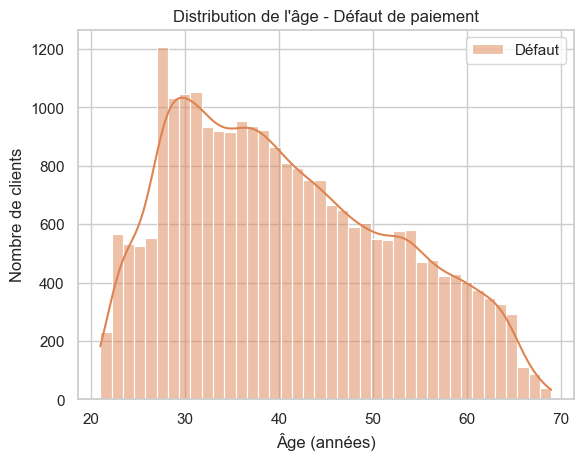

In [14]:
plt.figure(figsize=(8, 4))

sns.histplot(
    df[df["TARGET"] == 0]["AGE_YEARS"],
    bins=40,
    color=COLOR_NO_DEFAULT,
    label="Sans défaut",
    kde=True,
    # alpha=0.6
)
plt.xlabel("Âge (années)")
plt.ylabel("Nombre de clients")
plt.title("Distribution de l'âge - Pas de défaut de paiement")
plt.legend()
plt.show()

sns.histplot(
    df[df["TARGET"] == 1]["AGE_YEARS"],
    bins=40,
    color=COLOR_DEFAULT,
    label="Défaut",
    kde=True,
    # alpha=0.6
)
plt.xlabel("Âge (années)")
plt.ylabel("Nombre de clients")
plt.title("Distribution de l'âge - Défaut de paiement")
plt.legend()

plt.show()


Les clients les plus jeunes présentent une probabilité plus élevée de défaut de paiement.
Cette observation est cohérente avec l’intuition métier :
les profils plus jeunes ont souvent une situation financière moins stable.

In [15]:
age_data = df[['TARGET', 'AGE_YEARS']]
age_data['YEAR_BIN'] = pd.cut(age_data['AGE_YEARS'], bins=np.linspace(20, 70, 11))
age_groups  = age_data.groupby('YEAR_BIN').mean()
age_groups

,TARGET,AGE_YEARS
YEAR_BIN,,
"(20.0, 25.0]",0.123036,23.377522
"(25.0, 30.0]",0.111436,27.822518
"(30.0, 35.0]",0.102814,32.479037
"(35.0, 40.0]",0.089414,37.555913
"(40.0, 45.0]",0.078491,42.459346
"(45.0, 50.0]",0.074171,47.462741
"(50.0, 55.0]",0.066968,52.593136
"(55.0, 60.0]",0.055314,57.491131
"(60.0, 65.0]",0.052737,62.412459


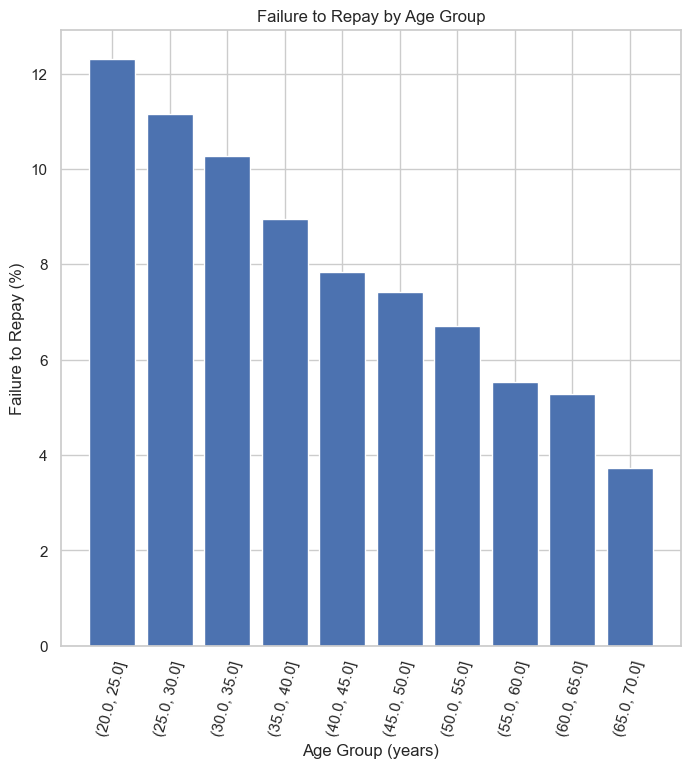

In [16]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

## Revenu annuel

In [17]:
df["AMT_INCOME_TOTAL"].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

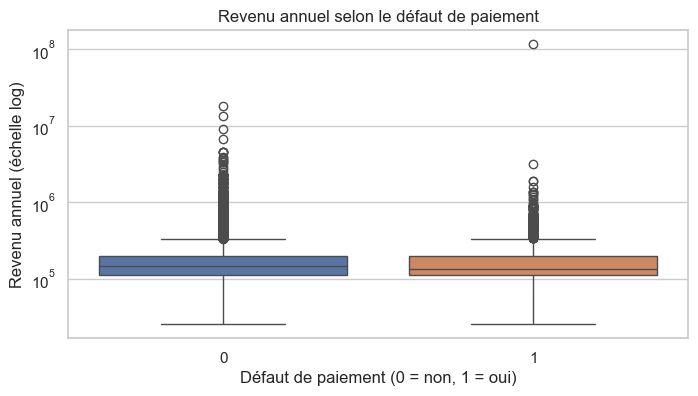

In [18]:
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=df,
    x="TARGET",
    y="AMT_INCOME_TOTAL",
    palette=[COLOR_NO_DEFAULT, COLOR_DEFAULT]
)
plt.yscale("log")
plt.title("Revenu annuel selon le défaut de paiement")
plt.xlabel("Défaut de paiement (0 = non, 1 = oui)")
plt.ylabel("Revenu annuel (échelle log)")
plt.show()


## Charge de crédit

In [19]:
# Ratio simple : annuité / crédit
df["PAYMENT_RATE"] = df["AMT_ANNUITY"] / df["AMT_CREDIT"]

df["PAYMENT_RATE"].describe()


count    307499.000000
mean          0.053695
std           0.022481
min           0.022073
25%           0.036900
50%           0.050000
75%           0.064043
max           0.124430
Name: PAYMENT_RATE, dtype: float64

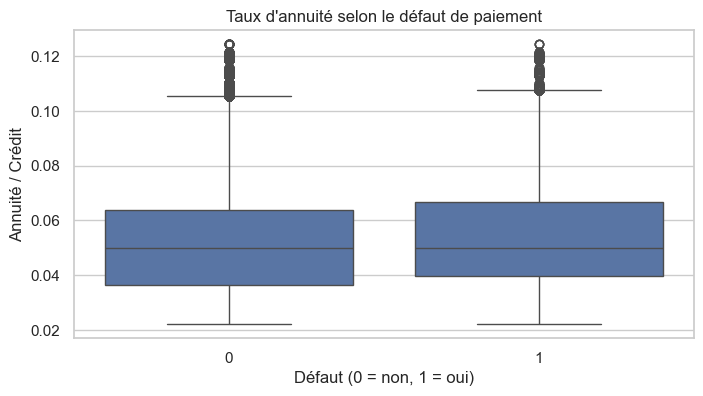

In [20]:
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=df,
    x="TARGET",
    y="PAYMENT_RATE"
)
plt.title("Taux d'annuité selon le défaut de paiement")
plt.xlabel("Défaut (0 = non, 1 = oui)")
plt.ylabel("Annuité / Crédit")
plt.show()


Les clients en défaut présentent généralement un taux d’annuité plus élevé,
ce qui traduit une charge de remboursement plus importante par rapport
au montant du crédit.

## Corrélations

In [21]:
# Find correlations with the target and sort
correlations = df.corr(numeric_only=True)['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
AGE_YEARS                    -0.078239
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226


In [22]:
ext_data = df[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,-0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,-0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,-0.205478
DAYS_BIRTH,0.078239,-0.600610,-0.091996,-0.205478,1.000000


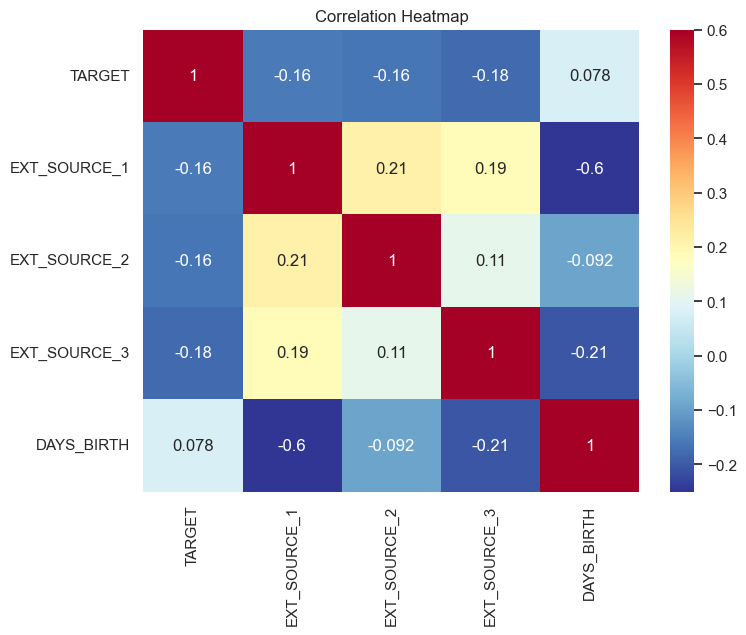

In [23]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

## Synthèse EDA

Cette analyse exploratoire ciblée met en évidence plusieurs signaux cohérents
avec les enjeux du scoring crédit :
- l’âge,
- le niveau de revenu,
- la charge de remboursement.

Ces variables constituent des candidates naturelles pour la phase
de préparation des données et de feature engineering.

Corrélations :
Les features sont en général peu corrélées avec la cible.
Le features engineering permettra d'améliorer les performances.

# Preprocessing

## Séparation X / y

In [24]:
TARGET = "TARGET"

X = df.drop(columns=[TARGET])
y = df[TARGET]

X.shape, y.shape


((307511, 123), (307511,))

## Nettoyage

### Valeurs manquantes

In [25]:
threshold = 0.5
cols_to_drop = missing_rate[missing_rate > threshold].index

len(cols_to_drop)


41

In [26]:
X = X.drop(columns=cols_to_drop)
X.shape


(307511, 82)

## Séparation train / test

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

X_train.shape, X_test.shape


((246008, 82), (61503, 82))

## Variables num / cat

In [28]:
from sklearn.compose import make_column_selector

num_cols = make_column_selector(dtype_include=np.number)(X_train)
cat_cols = make_column_selector(dtype_exclude=np.number)(X_train)


## Preprocessing num + cat

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# 1) Numériques : imputation médiane
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

# 2) Catégorielles : imputation + OHE
categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])

# 3) Assemblage
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, num_cols),
        ("cat", categorical_preprocess, cat_cols),
    ],
    remainder="drop"
)

preprocess


,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

# Entrainement

## Setup MLFlow

In [30]:
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("file:./mlruns")# dit à MLflow où stocker toutes les informations de tracking (paramètres, métriques, artefacts, etc.)
mlflow.set_experiment("oc_projet7 - première expérience")# dit à MLflow quel est le nom de l'expérience dans laquelle on va enregistrer les runs


2026/01/26 09:39:47 INFO mlflow.tracking.fluent: Experiment with name 'oc_projet7 - première expérience' does not exist. Creating a new experiment.


<Experiment: artifact_location=('file:c:/Users/utilisateur/Python/OC - Projet '
 '7/api-oc-projet7/mlruns/647716906739762579'), creation_time=1769416787923, experiment_id='647716906739762579', last_update_time=1769416787923, lifecycle_stage='active', name='oc_projet7 - première expérience', tags={}>

In [31]:
import time
import numpy as np
import os, mlflow
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def mlflow_run(
    run_name: str,
    model_pipe,
    X_train, y_train,
    X_test, y_test,
    threshold: float = 0.5,
    cost_fn: float = 50,
    cost_fp: float = 1,
    extra_params: dict | None = None
):
    if extra_params is None:
        extra_params = {}
    print("ENV MLFLOW_TRACKING_URI:", os.getenv("MLFLOW_TRACKING_URI"))
    print("MLflow get_tracking_uri:", mlflow.get_tracking_uri())
    with mlflow.start_run(run_name=run_name):
        # Fit + time
        t0 = time.perf_counter()
        model_pipe.fit(X_train, y_train)
        train_time = time.perf_counter() - t0

        # Probas
        proba = model_pipe.predict_proba(X_test)[:, 1]

        # Metrics
        auc = roc_auc_score(y_test, proba)
        y_pred = (proba >= threshold).astype(int)

        fn = np.sum((y_test.values == 1) & (y_pred == 0))  # défaut accordé
        fp = np.sum((y_test.values == 0) & (y_pred == 1))  # bon client refusé
        business_cost = cost_fn * fn + cost_fp * fp

        acceptance_rate = float(np.mean(proba < threshold))
        recall_def = float(np.sum((y_test.values == 1) & (y_pred == 1)) / np.sum(y_test.values == 1))
        precision_def = float(np.sum((y_test.values == 1) & (y_pred == 1)) / max(np.sum(y_pred == 1), 1))

        # Log params
        mlflow.log_param("threshold", float(threshold))
        mlflow.log_param("cost_fn", float(cost_fn))
        mlflow.log_param("cost_fp", float(cost_fp))
        for k, v in extra_params.items():
            mlflow.log_param(k, v)

        # Log metrics
        mlflow.log_metric("auc", float(auc))
        mlflow.log_metric("business_cost", float(business_cost))
        mlflow.log_metric("acceptance_rate", acceptance_rate)
        mlflow.log_metric("recall_defaut", recall_def)
        mlflow.log_metric("precision_defaut", precision_def)
        mlflow.log_metric("train_time_sec", float(train_time))

        # Confusion matrix artifact
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        fig, ax = plt.subplots()
        disp.plot(ax=ax, values_format="d")
        ax.set_title(f"{run_name} (t={threshold:.2f})")
        plt.tight_layout()
        fig_path = f"cm_{run_name}.png"
        plt.savefig(fig_path, dpi=160)
        plt.close(fig)
        mlflow.log_artifact(fig_path)

        # Log model (pipeline complet)
        mlflow.sklearn.log_model(model_pipe, name="model")

        return {
            "run_name": run_name,
            "auc": auc,
            "business_cost": business_cost,
            "threshold": threshold,
            "acceptance_rate": acceptance_rate,
            "recall_defaut": recall_def,
            "precision_defaut": precision_def,
            "train_time_sec": train_time
        }


## Fonction de coût métier

In [32]:
def business_cost(y_true, y_pred, cost_fn=10, cost_fp=1):
    """
    Coût métier :
    - FN (défaut accordé) : coût élevé
    - FP (bon client refusé) : coût faible
    """
    fn = np.sum((y_true == 1) & (y_pred == 0))  # défaut accordé
    fp = np.sum((y_true == 0) & (y_pred == 1))  # bon client refusé
    return cost_fn * fn + cost_fp * fp


## DummyClassifier

In [33]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score

dummy = DummyClassifier(strategy="most_frequent")

res_dummy = mlflow_run(
    run_name="dummy_most_frequent",
    model_pipe=dummy,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    threshold=0.5,
    extra_params={"model": "dummy", "strategy": "most_frequent"}
)
res_dummy

proba_dummy = dummy.predict_proba(X_test)[:, 1]
auc_dummy = res_dummy['auc']
auc_dummy


ENV MLFLOW_TRACKING_URI: file:./mlruns
MLflow get_tracking_uri: file:./mlruns


0.5

In [34]:
y_pred_dummy = (proba_dummy >= 0.5).astype(int)

cost_dummy = business_cost(
    y_test.values,
    y_pred_dummy,
    cost_fn=50,
    cost_fp=1
)

cost_dummy


np.int64(248250)

## Logistic Regression

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

baseline_model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1
)

baseline_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", baseline_model),
])

baseline_pipe


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [36]:
# baseline_pipe.fit(X_train, y_train)

# proba_test = baseline_pipe.predict_proba(X_test)[:, 1]
# auc = roc_auc_score(y_test, proba_test)

# auc

In [37]:
res_logreg = mlflow_run(
    run_name="logreg_baseline",
    model_pipe=baseline_pipe,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    threshold=0.5,
    extra_params={"model": "logreg", "class_weight": "balanced"}
)
auc = res_logreg['auc']
res_logreg


ENV MLFLOW_TRACKING_URI: file:./mlruns
MLflow get_tracking_uri: file:./mlruns


{'run_name': 'logreg_baseline',
 'auc': 0.6312754779227345,
 'business_cost': np.int64(120314),
 'threshold': 0.5,
 'acceptance_rate': 0.5700860120644521,
 'recall_defaut': 0.609667673716012,
 'precision_defaut': 0.11448129798419122,
 'train_time_sec': 253.67107519999263}

In [38]:
y_pred = (baseline_pipe.predict_proba(X_test)[:, 1] >= 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=3))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0      0.945     0.586     0.723     56538
           1      0.114     0.610     0.193      4965

    accuracy                          0.588     61503
   macro avg      0.530     0.598     0.458     61503
weighted avg      0.878     0.588     0.680     61503



array([[33124, 23414],
       [ 1938,  3027]])

Cette baseline présente un compromis typique d’un modèle entraîné
sur des données déséquilibrées avec une pondération des classes.

Le rappel élevé sur la classe “défaut” indique que le modèle détecte
une majorité des clients à risque, au prix d’un nombre important
de faux positifs. Ce comportement est cohérent avec l’utilisation
de `class_weight="balanced"`.

Ces résultats soulignent la nécessité d’introduire une logique métier
afin d’optimiser le seuil de décision en fonction des coûts associés
aux erreurs de classification.


### Score métier

**Score métier et seuil de décision**

Dans le contexte du scoring crédit, les erreurs de classification
n’ont pas le même impact métier.

Accorder un crédit à un client en défaut (faux positif métier)
entraîne une perte financière directe, tandis que refuser un crédit
à un client solvable (faux négatif métier) correspond à une perte
d’opportunité commerciale.

L’objectif n’est donc pas de maximiser l’accuracy, mais d’optimiser
le seuil de décision en fonction des coûts associés à chaque type
d’erreur.

## Recherche de seuil

In [39]:
import pandas as pd

thresholds = np.linspace(0, 1, 101)

results = []

proba_test = baseline_pipe.predict_proba(X_test)[:, 1]

for t in thresholds:
    y_pred_t = (proba_test >= t).astype(int)
    
    cost = business_cost(y_test.values, y_pred_t)
    
    results.append({
        "threshold": t,
        "business_cost": cost,
        "recall_defaut": np.sum((y_test == 1) & (y_pred_t == 1)) / np.sum(y_test == 1),
        "precision_defaut": np.sum((y_test == 1) & (y_pred_t == 1)) / max(np.sum(y_pred_t == 1), 1)
    })

results_df = pd.DataFrame(results)
results_df.head()

,threshold,business_cost,recall_defaut,precision_defaut
0,0.00,56538,1.0,0.080728
1,0.01,56538,1.0,0.080728
2,0.02,56538,1.0,0.080728
3,0.03,56538,1.0,0.080728
4,0.04,56537,1.0,0.080729


In [40]:
best_row = results_df.loc[results_df["business_cost"].idxmin()]
best_row

threshold               0.520000
business_cost       42047.000000
recall_defaut           0.544411
precision_defaut        0.122142
Name: 52, dtype: float64

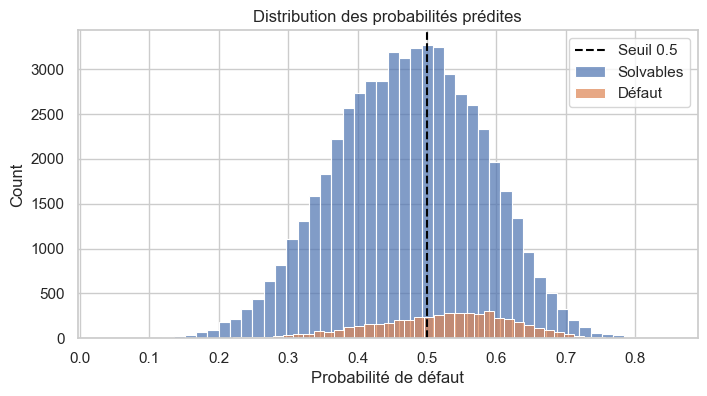

In [41]:
plt.figure(figsize=(8, 4))
sns.histplot(proba_test[y_test == 0], bins=50, label="Solvables", alpha=0.7)
sns.histplot(proba_test[y_test == 1], bins=50, label="Défaut", alpha=0.7)
plt.axvline(0.5, color="black", linestyle="--", label="Seuil 0.5")
plt.xlabel("Probabilité de défaut")
plt.title("Distribution des probabilités prédites")
plt.legend()
plt.show()

L’analyse de la distribution des probabilités prédites met en évidence
un fort recouvrement entre les clients solvables et les clients en défaut.
Dans ce contexte, le seuil de décision de 0.5 se situe au cœur des deux
distributions, ce qui limite fortement l’impact d’une optimisation du seuil.

Ce résultat est cohérent avec l’AUC obtenue et souligne que l’amélioration
des performances passe prioritairement par un enrichissement du modèle
(plutôt que par un simple ajustement du seuil).


## LightGBM

**Amélioration du modèle : LightGBM**

Les résultats obtenus avec la régression logistique montrent
un pouvoir discriminant limité, confirmé par la distribution
des probabilités prédites.

Nous testons à présent un modèle plus puissant, capable de
capturer des relations non linéaires, afin d’améliorer la
séparation entre clients solvables et clients en défaut.

### Définition et configuration

In [42]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    class_weight="balanced"
)

lgbm_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", lgbm_model),
])

lgbm_pipe


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

### Entrainement

In [43]:
res_lgbm = mlflow_run(
    run_name="lgbm_first_try",
    model_pipe=lgbm_pipe,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    threshold=0.5,
    extra_params={"model": "lightgbm", "min_acceptance": 0.40}
)
res_lgbm
auc_lgbm = res_lgbm['auc']

ENV MLFLOW_TRACKING_URI: file:./mlruns
MLflow get_tracking_uri: file:./mlruns
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5036
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 184
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


In [44]:
from sklearn.metrics import roc_auc_score

lgbm_pipe.fit(X_train, y_train)

proba_test_lgbm = lgbm_pipe.predict_proba(X_test)[:, 1]
auc_lgbm = roc_auc_score(y_test, proba_test_lgbm)

auc, auc_lgbm


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5036
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 184
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


(0.6312754779227345, 0.7650369274582126)

### Distributions

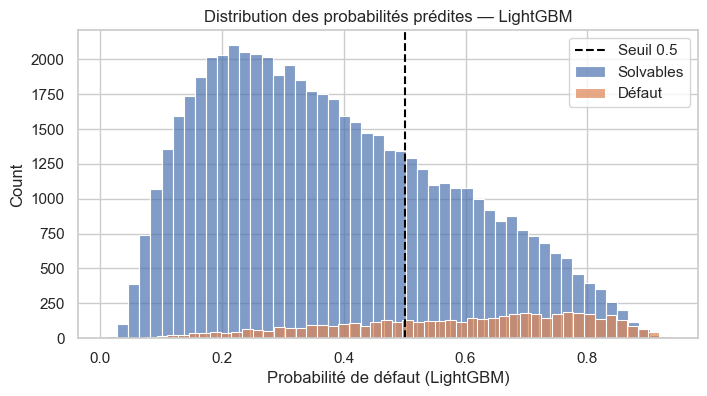

In [45]:
plt.figure(figsize=(8, 4))
sns.histplot(proba_test_lgbm[y_test == 0], bins=50, label="Solvables", alpha=0.7)
sns.histplot(proba_test_lgbm[y_test == 1], bins=50, label="Défaut", alpha=0.7)
plt.axvline(0.5, color="black", linestyle="--", label="Seuil 0.5")
plt.xlabel("Probabilité de défaut (LightGBM)")
plt.title("Distribution des probabilités prédites — LightGBM")
plt.legend()
plt.show()


La distribution des probabilités prédites par LightGBM montre une séparation
nettement plus marquée entre clients solvables et clients en défaut que la
régression logistique.

Cette meilleure séparation permet au score métier de jouer pleinement son rôle,
en ajustant le seuil de décision afin de minimiser le coût global des erreurs.


### Seuils

In [46]:
thresholds = np.linspace(0, 1, 101)

results_lgbm = []

for t in thresholds:
    y_pred_t = (proba_test_lgbm >= t).astype(int)
    cost = business_cost(
        y_test.values,
        y_pred_t,
        cost_fn=50,
        cost_fp=1
    )
    
    results_lgbm.append({
        "threshold": t,
        "business_cost": cost,
        "recall_defaut": np.sum((y_test == 1) & (y_pred_t == 1)) / np.sum(y_test == 1),
        "precision_defaut": np.sum((y_test == 1) & (y_pred_t == 1)) / max(np.sum(y_pred_t == 1), 1)
    })

results_lgbm_df = pd.DataFrame(results_lgbm)
results_lgbm_df.head()


,threshold,business_cost,recall_defaut,precision_defaut
0,0.00,56538,1.0,0.080728
1,0.01,56537,1.0,0.080729
2,0.02,56535,1.0,0.080732
3,0.03,56519,1.0,0.080753
4,0.04,56479,1.0,0.080805


In [47]:
best_lgbm = results_lgbm_df.loc[
    results_lgbm_df["business_cost"].idxmin()
]

best_lgbm


threshold               0.180000
business_cost       53917.000000
recall_defaut           0.972004
precision_defaut        0.093179
Name: 18, dtype: float64

In [48]:
best_threshold = best_lgbm["threshold"]

y_pred_lgbm_metier = (proba_test_lgbm >= best_threshold).astype(int)

print(f"Seuil métier LightGBM : {best_threshold:.2f}")
print(classification_report(y_test, y_pred_lgbm_metier, digits=3))
confusion_matrix(y_test, y_pred_lgbm_metier)


Seuil métier LightGBM : 0.18
              precision    recall  f1-score   support

           0      0.986     0.169     0.289     56538
           1      0.093     0.972     0.170      4965

    accuracy                          0.234     61503
   macro avg      0.539     0.571     0.229     61503
weighted avg      0.914     0.234     0.279     61503



array([[ 9571, 46967],
       [  139,  4826]])

L’optimisation du seuil de décision à l’aide du score métier conduit à un seuil
nettement inférieur à 0.5, traduisant une politique de crédit prudente.

Ce choix permet de détecter la quasi-totalité des clients en défaut, au prix
d’un nombre plus élevé de refus pour des clients solvables. Ce compromis est
cohérent avec le coût financier élevé associé à un défaut de paiement.


### Taux d'acceptation / refus

In [49]:
def acceptance_rate(y_pred):
    # y_pred=0 => crédit accordé (solvable), y_pred=1 => refus
    return np.mean(y_pred == 0)

def default_capture_rate(y_true, y_pred):
    # recall défaut
    return np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_true == 1)

acc_rate = acceptance_rate(y_pred_lgbm_metier)
rec_def = default_capture_rate(y_test.values, y_pred_lgbm_metier)

acc_rate, rec_def


(np.float64(0.1578784774726436), np.float64(0.9720040281973816))

### Contrainte métier sur le seuil

In [50]:
MIN_ACCEPTANCE = 0.40  # à discuter / ajuster

results_lgbm_df["acceptance_rate"] = results_lgbm_df["threshold"].apply(
    lambda t: np.mean((proba_test_lgbm < t))  # acceptés = proba < seuil
)

# Filtrer les seuils qui respectent la contrainte
feasible = results_lgbm_df[results_lgbm_df["acceptance_rate"] >= MIN_ACCEPTANCE].copy()

feasible.shape, feasible.head()


((69, 5),
     threshold  business_cost  recall_defaut  precision_defaut  acceptance_rate
 32       0.32          61244       0.880363          0.121704         0.416045
 33       0.33          61754       0.874119          0.124555         0.433459
 34       0.34          63400       0.863444          0.126883         0.450645
 35       0.35          64325       0.855791          0.129645         0.467115
 36       0.36          67099       0.840886          0.131397         0.483375)

In [51]:
best_feasible = feasible.loc[feasible["business_cost"].idxmin()]
best_feasible


threshold               0.320000
business_cost       61244.000000
recall_defaut           0.880363
precision_defaut        0.121704
acceptance_rate         0.416045
Name: 32, dtype: float64

In [52]:
t_real = best_feasible["threshold"]
y_pred_real = (proba_test_lgbm >= t_real).astype(int)

print(f"Seuil sous contrainte : {t_real:.2f}")
print("Taux d'acceptation :", np.mean(proba_test_lgbm < t_real))
print(classification_report(y_test, y_pred_real, digits=3))
confusion_matrix(y_test, y_pred_real)


Seuil sous contrainte : 0.32
Taux d'acceptation : 0.4160447457847585
              precision    recall  f1-score   support

           0      0.977     0.442     0.609     56538
           1      0.122     0.880     0.214      4965

    accuracy                          0.477     61503
   macro avg      0.549     0.661     0.411     61503
weighted avg      0.908     0.477     0.577     61503



array([[24994, 31544],
       [  594,  4371]])

L’optimisation du seuil uniquement sur la base du coût métier conduit à une
politique de décision excessivement conservatrice, peu compatible avec une
activité commerciale réelle.

En introduisant une contrainte sur le taux d’acceptation minimal, le seuil
de décision devient un levier d’arbitrage entre risque et opportunité.
Le seuil obtenu permet de maintenir un taux de détection élevé des clients
en défaut tout en conservant un niveau d’acceptation réaliste.


## Synthèse première expérience

In [53]:
comparison = pd.DataFrame([
    {
        "Model": "DummyClassifier",
        "AUC": auc_dummy,
        "Threshold": 0.5,
        "Business cost": cost_dummy,
        "Acceptance rate": np.mean(proba_dummy < 0.5)
    },
    {
        "Model": "Logistic Regression",
        "AUC": auc,
        "Threshold": 0.5,
        "Business cost": business_cost(
            y_test.values,
            (proba_test >= 0.5).astype(int),
            cost_fn=50,
            cost_fp=1
        ),
        "Acceptance rate": np.mean(proba_test < 0.5)
    },
    {
        "Model": "LightGBM (seuil métier)",
        "AUC": auc_lgbm,
        "Threshold": best_lgbm["threshold"],
        "Business cost": best_lgbm["business_cost"],
        "Acceptance rate": np.mean(proba_test_lgbm < best_lgbm["threshold"])
    },
    {
        "Model": "LightGBM (seuil contraint)",
        "AUC": auc_lgbm,
        "Threshold": best_feasible["threshold"],
        "Business cost": best_feasible["business_cost"],
        "Acceptance rate": best_feasible["acceptance_rate"]
    }
])

comparison


,Model,AUC,Threshold,Business cost,Acceptance rate
0,DummyClassifier,0.500000,0.50,248250.0,1.000000
1,Logistic Regression,0.631275,0.50,120314.0,0.570086
2,LightGBM (seuil métier),0.765037,0.18,53917.0,0.157878
3,LightGBM (seuil contraint),0.765037,0.32,61244.0,0.416045


# LightBGM CV

In [54]:
from scipy.stats import randint, uniform
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

RANDOM_STATE = 42

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

lgbm = LGBMClassifier(
    objective="binary",
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_estimators=500,      # on laisse un budget, la CV choisit les params qui marchent
    learning_rate=0.05,
)

lgbm_pipe_cv = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", lgbm),
])

param_distributions = {
    "model__num_leaves": randint(16, 128),
    "model__max_depth": randint(-1, 12),              # -1 = pas de limite
    "model__min_child_samples": randint(20, 200),
    "model__subsample": uniform(0.6, 0.4),            # [0.6, 1.0]
    "model__colsample_bytree": uniform(0.6, 0.4),     # [0.6, 1.0]
    "model__reg_alpha": uniform(0.0, 1.0),
    "model__reg_lambda": uniform(0.0, 3.0),
}


In [ ]:
search = RandomizedSearchCV(
    estimator=lgbm_pipe_cv,
    param_distributions=param_distributions,
    n_iter=40,                       # 30–80 selon ton temps machine
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    return_train_score=True
)

search.fit(X_train, y_train)

search.best_score_, search.best_params_


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5008
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 170
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

(np.float64(0.7603557918058661),
 {'model__colsample_bytree': np.float64(0.6027808522124762),
  'model__max_depth': 6,
  'model__min_child_samples': 174,
  'model__num_leaves': 24,
  'model__reg_alpha': np.float64(0.4848299713589832),
  'model__reg_lambda': np.float64(2.077308098670811),
  'model__subsample': np.float64(0.7077649335194086)})

best_score, best_params
(np.float64(0.7603557918058661),
 {'model__colsample_bytree': np.float64(0.6027808522124762),
  'model__max_depth': 6,
  'model__min_child_samples': 174,
  'model__num_leaves': 24,
  'model__reg_alpha': np.float64(0.4848299713589832),
  'model__reg_lambda': np.float64(2.077308098670811),
  'model__subsample': np.float64(0.7077649335194086)})

In [ ]:
best_score = 0.7603557918058661
best_params = {
    'model__colsample_bytree': np.float64(0.6027808522124762),
    'model__max_depth': 6,
    'model__min_child_samples': 174,
    'model__num_leaves': 24,
    'model__reg_alpha': np.float64(0.4848299713589832),
    'model__reg_lambda': np.float64(2.077308098670811),
    'model__subsample': np.float64(0.7077649335194086)
    }

In [65]:
best_lgbm_cv = search.best_estimator_
# best_lgbm_cv = LGBMClassifier(
#     objective="binary",
#     class_weight="balanced",
#     random_state=RANDOM_STATE,
#     n_estimators=500,
#     learning_rate=0.05,
#     colsample_bytree=0.6027808522124762,
#     max_depth=6,
#     min_child_samples=174,
#     num_leaves=24,
#     reg_alpha=0.4848299713589832,
#     reg_lambda=2.077308098670811,
#     subsample=0.7077649335194086
# )
# best_lgbm_cv_pipe = Pipeline(steps=[
#     ("preprocess", preprocess),
#     ("model", best_lgbm_cv),
# ])

# best_lgbm_cv_pipe.fit(X_train, y_train)

# proba_test_cv = best_lgbm_cv_pipe.predict_proba(X_test)[:, 1]


proba_test_cv = best_lgbm_cv.predict_proba(X_test)[:, 1]
auc_test_cv = roc_auc_score(y_test, proba_test_cv)

auc_test_cv


0.7674362584146545

In [66]:
with mlflow.start_run(run_name="lgbm_randomizedsearch_cv"):
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("n_iter", 40)
    mlflow.log_param("scoring", "roc_auc")

    # meilleurs params + score CV
    for k, v in search.best_params_.items():
        mlflow.log_param(k, v)

    mlflow.log_metric("best_cv_auc", float(search.best_score_))
    mlflow.log_metric("test_auc", float(auc_test_cv))

    # log modèle final (best estimator refit sur tout le train)
    mlflow.sklearn.log_model(best_lgbm_cv, artifact_path="model")


2026/01/26 10:50:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


In [67]:
best_idx = search.best_index_
mean_train = search.cv_results_["mean_train_score"][best_idx]
mean_valid = search.cv_results_["mean_test_score"][best_idx]

mean_train, mean_valid, (mean_train - mean_valid)


(np.float64(0.8204204071670919),
 np.float64(0.7603557918058661),
 np.float64(0.06006461536122576))

## Features importance

### Globale

In [68]:
# Récupération du preprocessing
preprocess_fitted = best_lgbm_cv.named_steps["preprocess"]

# Colonnes numériques
num_features = preprocess_fitted.transformers_[0][2]

# Colonnes catégorielles (OneHot)
cat_transformer = preprocess_fitted.transformers_[1][1]
cat_features = cat_transformer.get_feature_names_out(
    preprocess_fitted.transformers_[1][2]
)

feature_names = np.concatenate([num_features, cat_features])

len(feature_names)


195

In [69]:
importances = best_lgbm_cv.named_steps["model"].feature_importances_

fi_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
)

fi_df.head(20)

,feature,importance
68,PAYMENT_RATE,1185
28,EXT_SOURCE_3,683
27,EXT_SOURCE_2,657
8,DAYS_EMPLOYED,495
3,AMT_CREDIT,474
4,AMT_ANNUITY,466
40,DAYS_LAST_PHONE_CHANGE,451
10,DAYS_ID_PUBLISH,436
9,DAYS_REGISTRATION,434
5,AMT_GOODS_PRICE,412


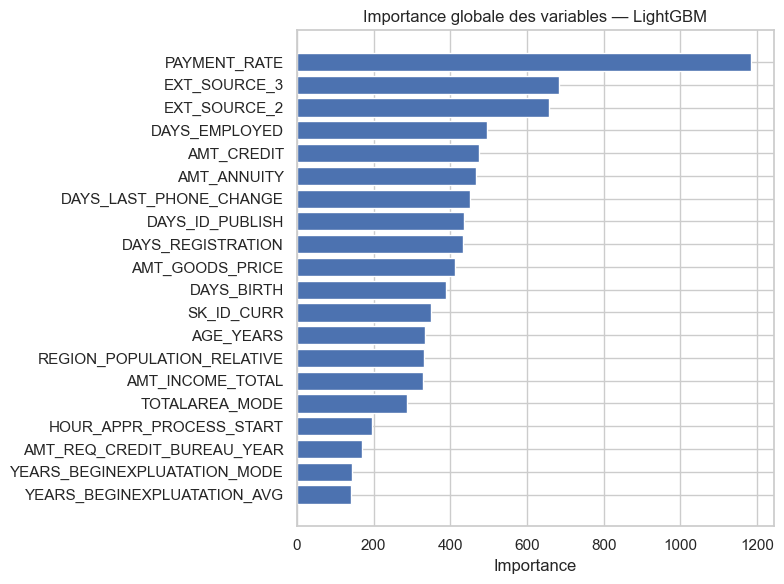

In [70]:
top_n = 20
plt.figure(figsize=(8, 6))
plt.barh(
    fi_df.head(top_n)["feature"][::-1],
    fi_df.head(top_n)["importance"][::-1]
)
plt.title("Importance globale des variables — LightGBM")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### Importance globale des variables (LightGBM)

L’analyse des importances met en évidence trois familles de variables clés :

- **Capacité de remboursement** : ratios et montants liés au crédit (`PAYMENT_RATE`, `AMT_ANNUITY`, `AMT_CREDIT`, `AMT_GOODS_PRICE`)
- **Information externe** : scores agrégés (`EXT_SOURCE_2`, `EXT_SOURCE_3`)
- **Stabilité / ancienneté** : variables temporelles (`DAYS_EMPLOYED`, `DAYS_LAST_PHONE_CHANGE`, `DAYS_ID_PUBLISH`, `DAYS_REGISTRATION`)

Ces résultats sont cohérents avec la problématique métier : le risque de défaut dépend fortement de la solvabilité (effort de remboursement), de l’historique/score externe et de la stabilité du profil client.


### Shap

In [71]:
import shap
# Transformation des données (après preprocessing)
X_test_transformed = preprocess_fitted.transform(X_test)

explainer = shap.TreeExplainer(best_lgbm_cv.named_steps["model"])
shap_values = explainer.shap_values(X_test_transformed)

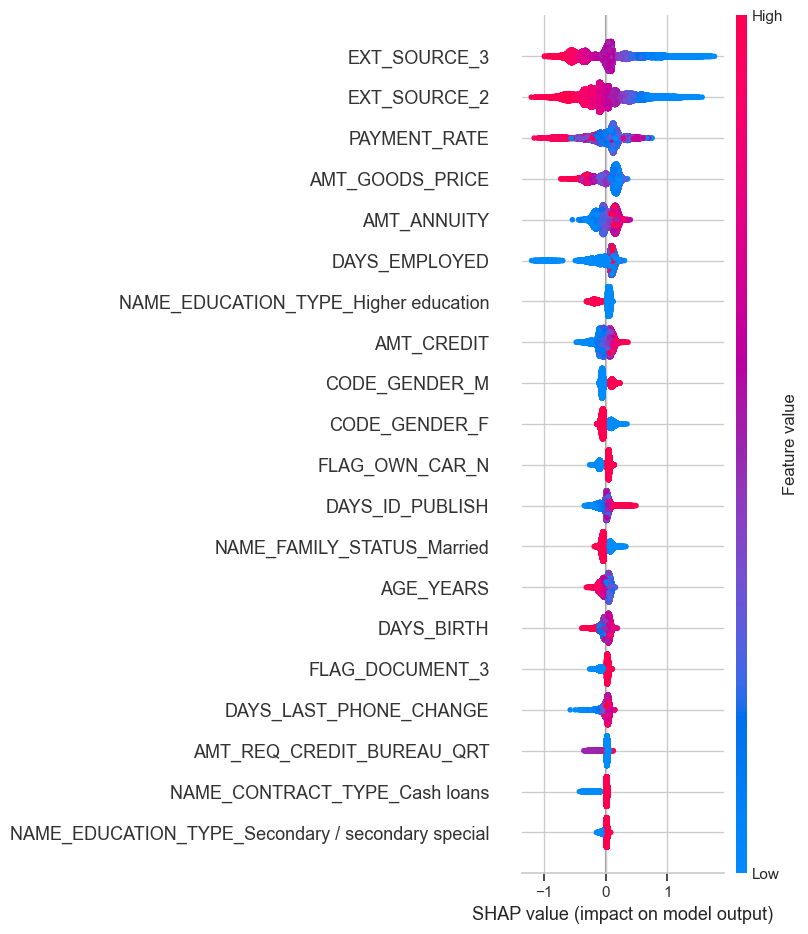

In [72]:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names,
    max_display=20
)

Le graphique SHAP global montre non seulement quelles variables sont
importantes, mais aussi dans quel sens elles influencent la prédiction.

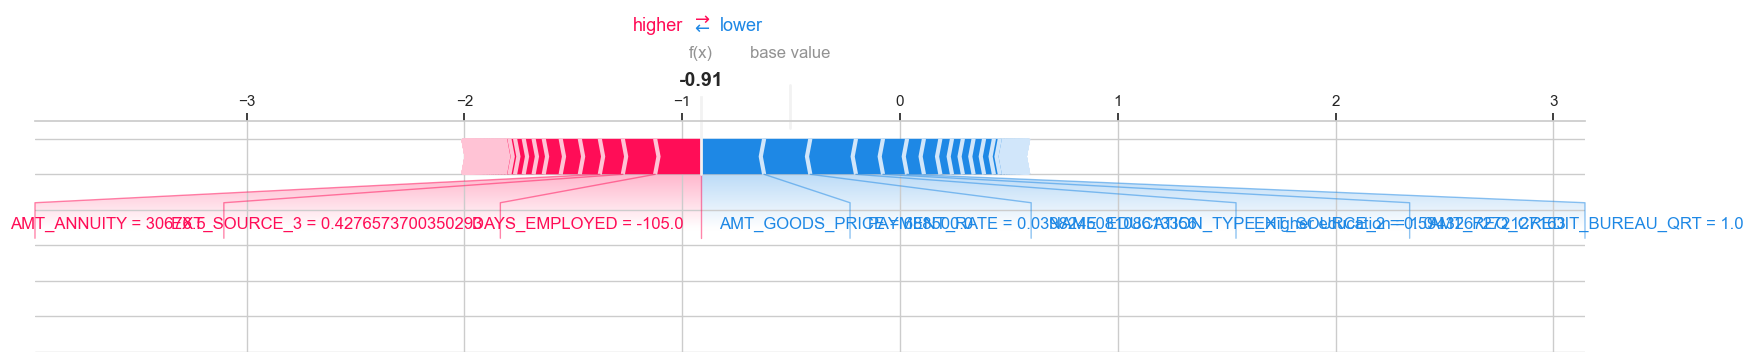

In [73]:
idx = 0  # n’importe quel individu du test
shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X_test_transformed[idx],
    feature_names=feature_names,
    matplotlib=True
)

Le modèle part d’un risque moyen, puis explique la décision pour ce client.
Certains éléments comme une mensualité élevée ou un score externe moyen
augmentent le risque, mais ils sont compensés par un faible effort de
remboursement et des signaux de stabilité. La combinaison de ces facteurs
conduit à une probabilité finale de défaut faible, ce qui justifie
l’acceptation du client.